In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal, Laplace
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch
import scipy.io as sio
import random
import numpy as np
import import_ipynb
import dataloader_mnist
import networks_mnist
from model import PixelCNN
from torchviz import make_dot
from tqdm import tqdm

importing Jupyter notebook from dataloader_mnist.ipynb
importing Jupyter notebook from networks_mnist.ipynb


In [2]:
# class CategoricalImage(torch.distributions.Categorical):
#     def __init__(self, logits):
#         logits = logits.transpose(-1, -2)
# #         print(logits.shape)
# #         logits = logits.flatten(-3, -1).transpose(-1, -2)
#         super(CategoricalImage, self).__init__(logits=logits.to(dtype=torch.float64))
#     def log_prob(self, target):
# #         print(target.shape)
# #         target = target.flatten(-3, -1)
#         shape, dtype = target.shape, target.dtype
#         if target.max() <= 1:
#             target = (target * 255).to(torch.long)
#         print(target.shape, self.probs.shape)
#         ret = super(CategoricalImage, self).log_prob(target)
#         return ret.view(shape[0], -1, *shape[2:]).to(dtype=dtype)

In [3]:
batch_size = 128
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
lat_dim = 32

In [4]:
MNIST_PATH = "/home/achint/old_files/VAE/MNIST/MNIST/processed/%s.pt"
dataset_train = dataloader_mnist.MNIST(mnist_pt_path = MNIST_PATH % 'training')
dataset_test  = dataloader_mnist.MNIST(mnist_pt_path = MNIST_PATH % 'test')
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=True, drop_last=True)

In [5]:
enc_mnist = networks_mnist.EncMNIST(lat_dim).to(device)
dec_mnist = networks_mnist.pixelcnn_decoder(PixelCNN(lat_dim+10, 1)).to(device)

# dec_mnist = networks_mnist.pixelcnn_decoder(PixelCNN(1,lat_dim,3,6,1)).to(device)

# dec_mnist = networks_mnist.DecMNIST(lat_dim).to(device)

In [6]:
# class decoder:
#     #__init__
#     #...
#     def forward(self, z, x, ...):
#         #....calc
#         return x_rec, rec_loss # == - log_like

In [7]:
class Vanilla_VAE(nn.Module):
    def __init__(self, encoder, decoder, batch_size=batch_size):
        super(Vanilla_VAE,self).__init__()
        self.batch_size = batch_size
        self.encoder = encoder
        self.decoder = decoder
        
    def encode(self, x):
        param1, param2 = self.encoder(x)
        return param1, param2
    
    def sampling(self, mu, std):
        
        eps = torch.randn_like(std)
        return eps * std + mu
    
    def decode(self, z,x, label, generate_mode,mu, log_var):
        z_cond = torch.cat((z,label),1 )
        x_rec = self.decoder(z_cond, x, generate_mode,mu, log_var)
        return x_rec
   
    def forward(self, x, generate_mode = False):
        img = x[:,0:784]
        label = x[:,784:794]
        mu, log_var = self.encode(img)
        std = torch.exp(0.5 * log_var)
        if generate_mode:
            z = self.sampling(torch.zeros_like(mu), torch.ones_like(std))
            x_rec,total_loss,rec_loss,kl_loss = self.decode(z,torch.zeros_like(img),label, generate_mode, mu, log_var)
            total_loss,rec_loss,kl_loss = 0, 0, 0
        else:
            z = self.sampling(mu, std)
            x_rec,total_loss, rec_loss,kl_loss = self.decode(z,img,label, generate_mode,mu, log_var)
#             total_loss, rec_loss,kl_loss = self.loss_function(x_rec, img)
            
        results = {'data':x,'x_rec': x_rec,
            'total_loss': total_loss, 'rec_losses': rec_loss, 'KL_loss': kl_loss}
        return results


In [8]:
vae = Vanilla_VAE(enc_mnist,dec_mnist, batch_size=batch_size).to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

In [9]:
def train(model,train_loader,epoch):
    model.train()
    for k, data in (enumerate(train_loader)):
        optimizer.zero_grad()
        results = model(data[0].to(device))
        torch.autograd.set_detect_anomaly(True)
        results['total_loss'].backward() 
        optimizer.step()    
    return results

In [10]:
epoch  = 0
epochs = 1 + epoch
tot_loss_epoch = np.zeros(epochs)
rec_loss_epoch = np.zeros(epochs)
KL_loss_epoch  = np.zeros(epochs)
for epoch in tqdm(range(epoch, epochs)):
    results = train(vae,train_loader,epoch)
    tot_loss_epoch[epoch] = results['total_loss'].cpu()
    rec_loss_epoch[epoch] = results['rec_losses'].cpu()
    KL_loss_epoch[epoch]  = results['KL_loss'].cpu()

100%|█████████████████████████████████████████████| 1/1 [01:04<00:00, 64.38s/it]


In [18]:
tot_loss_epoch

array([98746.8671875])

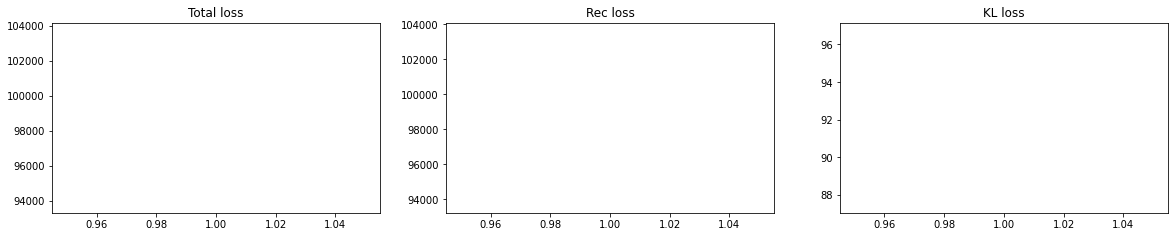

In [19]:
epoch_array = np.linspace(1,epochs,epochs)
fig, axs = plt.subplots(1,3,figsize=(20, 3.5))
axs[0].plot(epoch_array, tot_loss_epoch)
axs[0].set_title('Total loss')
axs[1].plot(epoch_array, rec_loss_epoch)
axs[1].set_title('Rec loss')
axs[2].plot(epoch_array, KL_loss_epoch)
axs[2].set_title('KL loss')
plt.show()

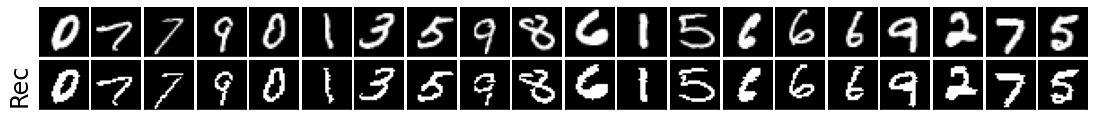

In [20]:
x_rec = results['x_rec'].max(dim=1).indices.squeeze()
data  = results['data'][:,0:784]

ncols = min(len(x_rec[0]), 20)
fig, ax = plt.subplots(nrows=2, ncols=ncols, figsize=(15, 1.5))
for i, aux in enumerate(zip(data, x_rec)):
    if i>= ncols:
        break
    for j, im in enumerate(aux):
        ax[j, i].imshow(im.detach().cpu().numpy().reshape(28, 28), cmap='gray')
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
ax[1, 0].set_ylabel('Rec', fontsize=24)
fig.tight_layout(pad=0)

In [21]:
x_rec = results['x_rec']
x_rec.size()

torch.Size([128, 256, 1, 28, 28])

In [15]:
data  = results['data'][:,0:784]
data.min()

tensor(0., device='cuda:0')

In [16]:
## Generation of images
def generate(model,train_loader,generate_mode):
#     model.eval()
    for k, data in (enumerate(train_loader)):
        if k>=1:
            break
        results = model(data[0].to(device),generate_mode)
        
#         color_level = 256
#         x = (data[0] * (color_level - 1)).floor().long()
#         results['data'] = x
    return results

In [17]:
results_generate = generate(vae,train_loader,generate_mode= True)

RuntimeError: 0D or 1D target tensor expected, multi-target not supported

In [ ]:
x_rec = results_generate['x_rec'].squeeze()
x_rec.mean()

In [ ]:
data  = (results_generate['data'])[:,0:784]
data.mean()

In [ ]:
data.max()

In [ ]:
z = vae_.encode()
vae_.decoder.pixelcnn()

In [ ]:
# x_rec = results_generate['x_rec']
# x_rec = results_generate['x_rec'].squeeze()
x_rec = results['x_rec'].max(dim=1).indices.squeeze()

# data  = torch.zeros_like(results_generate['data'])[:,0:784]
# data  = torch.zeros_like(results_generate['data'])[:,0:784]
data  = (results_generate['data'])[:,0:784]

print(results_generate['x_rec'].shape, results_generate['data'].shape)

ncols = min(len(x_rec[0]), 20)
fig, ax = plt.subplots(nrows=2, ncols=ncols, figsize=(15, 1.5))
for i, aux in enumerate(zip(data, x_rec)):
    if i>= ncols:
        break
    for j, im in enumerate(aux):
        ax[j, i].imshow(im.detach().cpu().numpy().reshape(28, 28), cmap='gray')
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
ax[1, 0].set_ylabel('Rec', fontsize=24)
fig.tight_layout(pad=0)

In [ ]:
results_generate['x_rec'].min()

In [ ]:
plt.imshow(data[1,:].reshape(28, 28).cpu())

In [ ]:
import importlib
import model
importlib.reload(model)
from model import PixelCNN

In [ ]:
enc_mnist = networks_mnist.EncMNIST(lat_dim).to(device)
dec_mnist = networks_mnist.pixelcnn_decoder(PixelCNN(lat_dim+10, 1)).to(device)
vae_ = Vanilla_VAE(enc_mnist,dec_mnist, batch_size=batch_size).to(device)
vae_.load_state_dict(vae_.state_dict())

In [ ]:
x = "hello"
assert x == "goodbye"
print('hello')

In [ ]:
total_loss,rec_loss,kl_loss = 0,0 ,0


In [ ]:
label = F.one_hot(torch.tensor(5),num_classes=10)
label.size()

In [ ]:
label = label.repeat(120, 1)

In [ ]:
label.size()